# Assignment 3 — Part 3: Image Inference & Visualization

Abhinav Kumar
11/2/2025

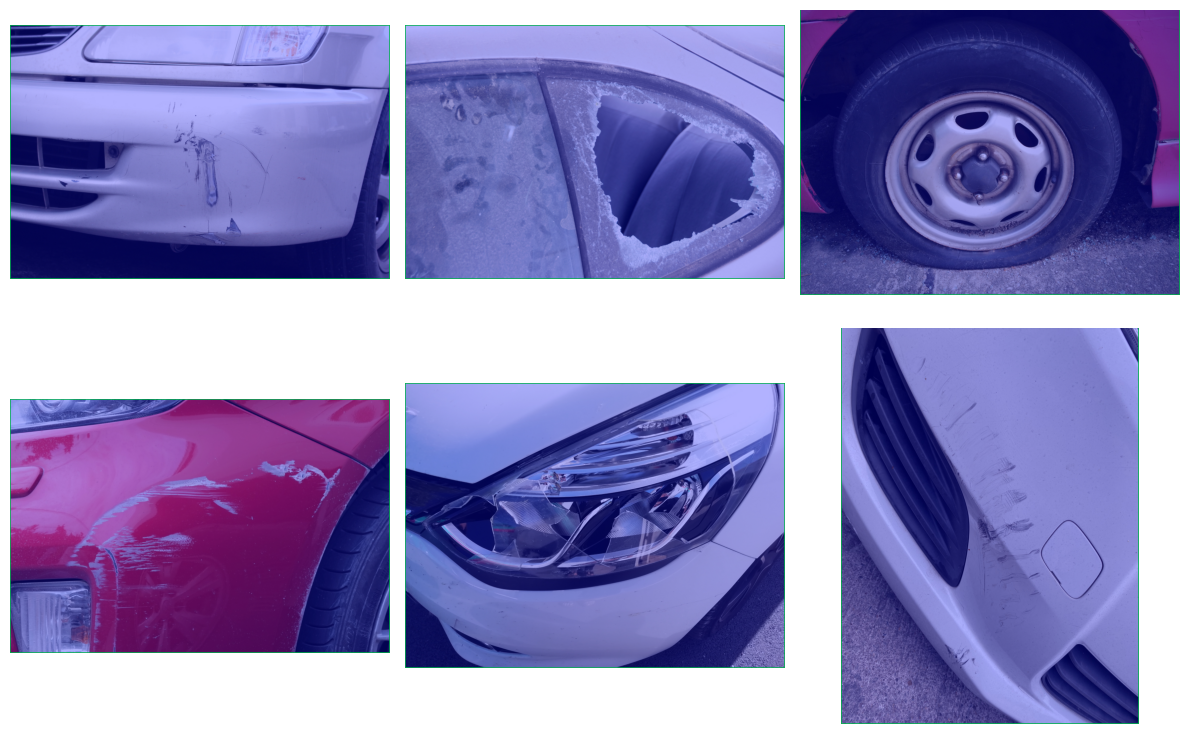

In [7]:
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F, timm, random, cv2
from torchvision import transforms as T
from PIL import Image
from datasets import load_dataset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_c, out_c, k=3, s=1, p=1):
        super().__init__(nn.Conv2d(in_c, out_c, k, s, p, bias=False),
                         nn.BatchNorm2d(out_c), nn.ReLU(inplace=True))
def make_backbone(name="vit_base_patch16_224.dino"):
    try:
        m = timm.create_model(name, features_only=True, pretrained=True)
        ch = m.feature_info.channels()
    except Exception:
        m = timm.create_model("resnet50", features_only=True, pretrained=True)
        ch = m.feature_info.channels()
    return m, ch
class FPNDecoder(nn.Module):
    def __init__(self, feat_channels, out_ch=128):
        super().__init__()
        self.lat = nn.ModuleList([nn.Conv2d(c, out_ch, 1) for c in feat_channels])
        self.smooth = nn.ModuleList([ConvBNReLU(out_ch, out_ch) for _ in feat_channels])
    def forward(self, feats):
        feats = feats[-4:] if len(feats)>=4 else feats
        x=None; outs=[]
        for i in reversed(range(len(feats))):
            f = self.lat[i](feats[i])
            if x is None: x=f
            else: x = f + F.interpolate(x, size=f.shape[-2:], mode="bilinear", align_corners=False)
            x = self.smooth[i](x); outs.append(x)
        outs = list(reversed(outs))
        size = outs[0].shape[-2:]
        up = [F.interpolate(o, size, mode='bilinear', align_corners=False) for o in outs]
        return torch.cat(up, dim=1)
class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone, ch = make_backbone()
        for p in self.backbone.parameters(): p.requires_grad=False
        self.decoder = FPNDecoder(ch)
        self.head = nn.Sequential(ConvBNReLU(128*min(4, len(ch)), 256),
                                  ConvBNReLU(256, 128),
                                  nn.Conv2d(128, 1, 1))
    def forward(self, x):
        feats = self.backbone(x)
        dec = self.decoder(feats)
        logit = self.head(dec)
        return F.interpolate(logit, size=x.shape[-2:], mode="bilinear", align_corners=False)

model = SegModel().to(device).eval()
ds = load_dataset("harpreetsahota/CarDD")
key = "train" if "train" in ds else list(ds.keys())[0]
split = ds[key]

t_img = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor()])

def infer_pil(pil):
    x = t_img(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        prob = torch.sigmoid(model(x))[0,0].cpu().numpy()
    return prob

def vis_one(pil, prob, thr=0.5):
    img = np.array(pil.convert("RGB"))
    mask_small = (prob>thr).astype(np.uint8)
    mask = cv2.resize(mask_small, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    ys, xs = np.where(mask>0)
    out = img.copy()
    if len(xs)>0 and len(ys)>0:
        x1,x2,y1,y2 = xs.min(), xs.max(), ys.min(), ys.max()
        cv2.rectangle(out, (x1,y1),(x2,y2),(0,255,0),2)
    color = np.zeros_like(out); color[...,2]=255
    overlay = (out*0.7 + color*0.3*mask[...,None]).astype(np.uint8)
    return overlay

fig, axes = plt.subplots(2,3, figsize=(12,8))
for ax in axes.ravel():
    ex = split[random.randint(0, len(split)-1)]
    pil = ex["image"] if isinstance(ex["image"], Image.Image) else Image.fromarray(ex["image"])
    prob = infer_pil(pil)
    vis = vis_one(pil, prob, thr=0.5)
    ax.imshow(vis); ax.axis("off")
plt.tight_layout(); plt.show()